Install + Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.19.0


In [ ]:
!nvidia-smi

Mon Dec  1 02:34:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.7.4.2 --quiet
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"erickumara","key":"b0c5c0a20bb90c102a85f16e4a1728b4"}')

!chmod 600 /root/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 18.1 MB/s eta 0:00:00


In [ ]:
# Datasets
# https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset 7 columns
# https://www.kaggle.com/datasets/llabhishekll/fraud-email-dataset 2 columns

!mkdir '/content/data'

!kaggle datasets download -d naserabdullahalam/phishing-email-dataset
!unzip -qo 'phishing-email-dataset.zip' -d '/content/data'
!rm 'phishing-email-dataset.zip'

!kaggle datasets download -d llabhishekll/fraud-email-dataset
!unzip -qo 'fraud-email-dataset.zip' -d '/content/data'
!rm 'fraud-email-dataset.zip'

Dataset URL: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset
License(s): CC-BY-SA-4.0
Dataset URL: https://www.kaggle.com/datasets/llabhishekll/fraud-email-dataset
License(s): unknown


Load Dataset Folder + Normalize Columns

In [ ]:
import os

data_path = "/content/data"

all_df = []

for file in os.listdir(data_path):
    df = pd.read_csv(os.path.join(data_path, file))

    # Normalizing all datasets to columns: body, label
    if {'body', 'label'}.issubset(df.columns):
        pass
    elif {'Text', 'Class'}.issubset(df.columns):
        df = df.rename(columns={'Text':'body','Class':'label'})
    elif {'text_combined','label'}.issubset(df.columns):
        df = df.rename(columns={'text_combined':'body'})
    elif 'message' in df.columns:
        df = df.rename(columns={'message':'body'})

    df = df[['body','label']]
    all_df.append(df)

    print(f"Loaded: {file}")
    print(df.head(1))
    print("-"*40)

final_df = pd.concat(all_df, ignore_index=True)
final_df.dropna(inplace=True)
final_df['label'] = final_df['label'].astype(int)

final_df.head()


Loaded: Ling.csv
                                                body  label
0  content - length : 3386 apple-iss research cen...      0
----------------------------------------
Loaded: fraud_email_.csv
                                                body  label
0  Supply Quality China's EXCLUSIVE dimensions at...      1
----------------------------------------
Loaded: CEAS_08.csv
                                                body  label
0  Buck up, your troubles caused by small dimensi...      1
----------------------------------------
Loaded: Nazario.csv
                                                body  label
0  This text is part of the internal format of yo...      1
----------------------------------------
Loaded: Nigerian_Fraud.csv
                                                body  label
0  FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...      1
----------------------------------------
Loaded: Enron.csv
                                                body  label
0  ( see

,body,label
0,content - length : 3386 apple-iss research cen...,0
1,"lang classification grimes , joseph e . and ba...",0
2,i am posting this inquiry for sergei atamas ( ...,0
3,a colleague and i are researching the differin...,0
4,earlier this morning i was on the phone with a...,0


Mask URLs

In [ ]:
import re

url_pattern = r'(https?://|www\.)\S+'
mask_token = '[URL]'

final_df['body'] = final_df['body'].replace(
    to_replace=url_pattern,
    value=mask_token,
    regex=True
)

final_df.head(10)


,body,label
0,content - length : 3386 apple-iss research cen...,0
1,"lang classification grimes , joseph e . and ba...",0
2,i am posting this inquiry for sergei atamas ( ...,0
3,a colleague and i are researching the differin...,0
4,earlier this morning i was on the phone with a...,0
5,content - length : 4437 call for papers is the...,0
6,m . a . in scandinavian linguistics at the uni...,0
7,call for papers linguistics session - - midwes...,0
8,content - length : 1937 greetings ! i ' m wond...,0
9,fulbright announcement : please post / dissemi...,0


Train / Val / Test Split

In [ ]:
X = final_df['body'].astype(str).values
y = final_df['label'].values

# Train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)


(141519, 17690, 17690)

TextVectorization Tokenizer

In [ ]:
MAX_VOCAB = 10000
MAX_LEN   = 100

vectorizer = layers.TextVectorization(
    max_tokens=MAX_VOCAB,
    output_mode="int",
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation"
)

text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(256)
vectorizer.adapt(text_ds)

def vectorize(x, y):
    return vectorizer(x), y


Create tf.data datasets

In [ ]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
    .batch(BATCH_SIZE).map(vectorize).prefetch(1)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))\
    .batch(BATCH_SIZE).map(vectorize).prefetch(1)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
    .batch(BATCH_SIZE).map(vectorize).prefetch(1)


CNN + BiLSTM Model (From Scratch)

In [ ]:
# (100k params) #

MAX_VOCAB = 3000      # smaller vocab
EMBED_DIM = 32        # smaller embedding
NUM_HEADS = 2
FF_DIM = 64
DROPOUT = 0.3

def transformer_block(inputs, embed_dim, num_heads, ff_dim, rate=DROPOUT):

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim,
        dropout=rate
    )(x, x)

    x = layers.Add()([attn_output, inputs])
    x_norm = layers.LayerNormalization(epsilon=1e-6)(x)

    ffn = layers.Dense(ff_dim, activation="relu")(x_norm)
    ffn = layers.Dense(embed_dim)(ffn)

    x = layers.Add()([ffn, x])
    return x

inputs = keras.Input(shape=(MAX_LEN,), dtype="int32")
x = layers.Embedding(MAX_VOCAB, EMBED_DIM)(inputs)

x = transformer_block(x, EMBED_DIM, NUM_HEADS, FF_DIM)

x = layers.GlobalMaxPooling1D()(x)

x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(DROPOUT)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 32)   │     96,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 32)   │         64 │ embedding[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 32)   │      8,416 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 32)   │          0 │ multi_head_atten… │
│                     │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 32)   │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 64)   │      2,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100, 32)   │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 32)   │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ add_1[0][0]       │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,056 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 109,825 (429.00 KB)

 Trainable params: 109,825 (429.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
total_params = model.count_params()
print(f"Total Trainable Parameters: {total_params:,}")


Total Trainable Parameters: 109,825


Class Weights

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
class_weights


{0: 1.0292889768131963, 1: 0.9723317713987331}

Compile Model

In [ ]:
METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=METRICS,
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2
    )
]


Train Model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
  )


Epoch 1/20
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.9860 - loss: 0.0387 - precision: 0.9858 - recall: 0.9870 - val_accuracy: 0.9724 - val_loss: 0.0760 - val_precision: 0.9562 - val_recall: 0.9916 - learning_rate: 0.0010
Epoch 2/20
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9866 - loss: 0.0366 - precision: 0.9866 - recall: 0.9872 - val_accuracy: 0.9700 - val_loss: 0.0935 - val_precision: 0.9507 - val_recall: 0.9931 - learning_rate: 0.0010
Epoch 3/20
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.9872 - loss: 0.0342 - precision: 0.9870 - recall: 0.9880 - val_accuracy: 0.9773 - val_loss: 0.0725 - val_precision: 0.9650 - val_recall: 0.9919 - learning_rate: 0.0010
Epoch 4/20
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.9885 - loss: 0.0312 - precision: 0.9882 - recall: 0.9894 - val_accuracy: 0.9663 - val_loss: 0.1008 - val_precision: 0.9420 - val_recall: 0.9958 - learning_rate: 0.0010
Epoch 5/20
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/st

Evaluate on Test Set

In [ ]:
test_results = model.evaluate(test_ds, return_dict=True)
test_results


553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9826 - loss: 0.0855 - precision: 0.9759 - recall: 0.9908


{'accuracy': 0.983154296875,
 'loss': 0.08289752900600433,
 'precision': 0.9767038822174072,
 'recall': 0.9908761382102966}

Predictions + Metrics

In [ ]:
# Probabilities
y_prob = model.predict(test_ds)
y_pred = (y_prob.flatten() > 0.5).astype(int)

# True labels
y_true = np.concatenate([y for _, y in test_ds])

print(classification_report(y_true, y_pred))


553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8593
           1       0.98      0.99      0.98      9097

    accuracy                           0.98     17690
   macro avg       0.98      0.98      0.98     17690
weighted avg       0.98      0.98      0.98     17690



Confusion Matrix Plot

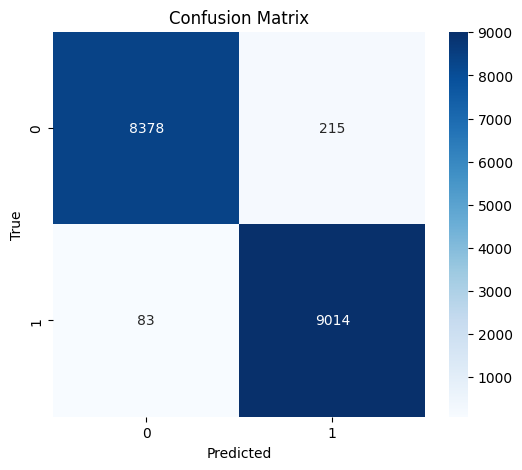

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
